# CIS6800: Project 6: SegFormer

### Instructions:
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction

SegFormer is a simple architecture with some key innovations that allow it to acheive state of the art performance at much higher speeds and fewer parameters than other competing methods. In this assignment, you will be implementing the building blocks of SegFormer. An overview of the architecture is provided below.

It is highly encouraged for you to review the SegFormer paper, available [here](https://arxiv.org/pdf/2105.15203.pdf). In particular, Section 3 contains detailed descriptions of the modules you will be implementing.

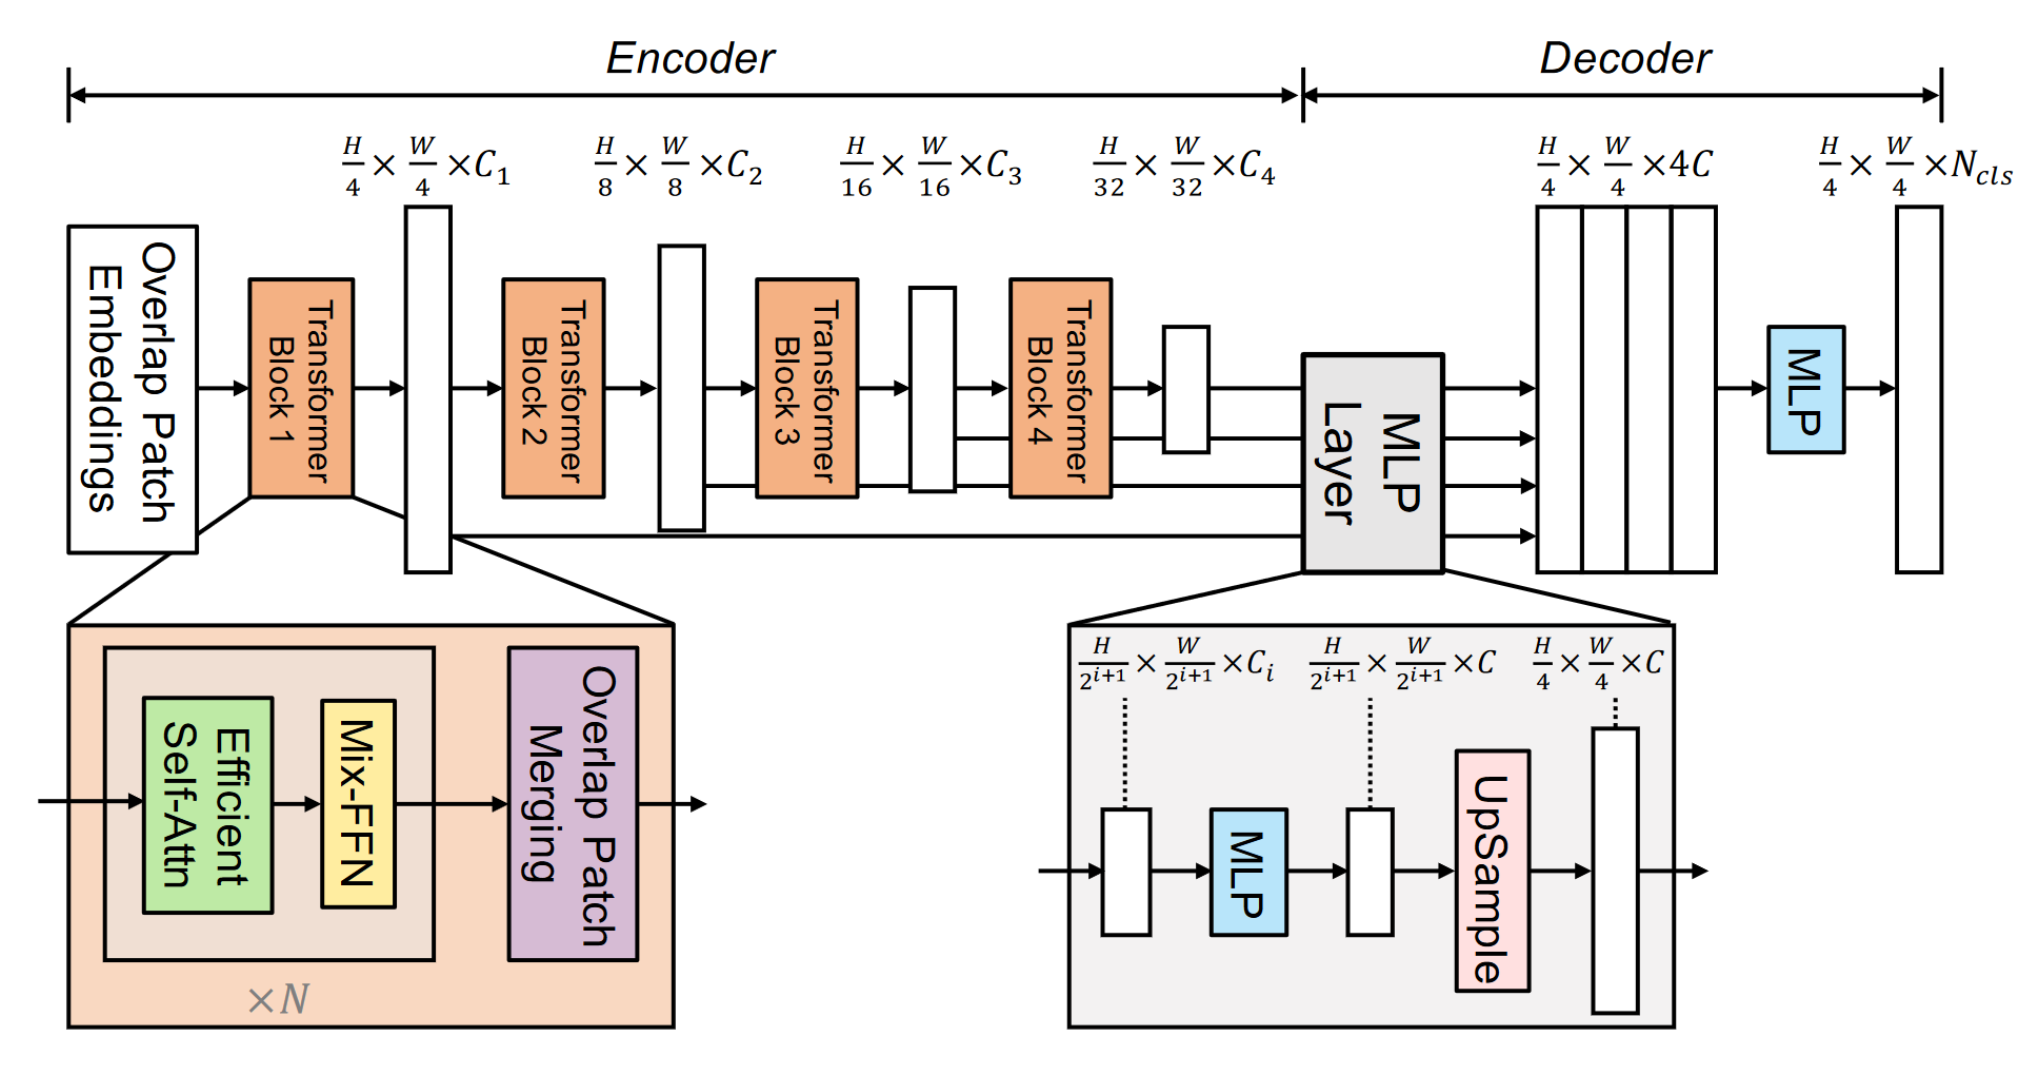

In [1]:
!pip install pytorch-lightning torchbench
!pip install mmcv-full==1.2.7

import torch
from torch import nn
import numpy as np
import pytorch_lightning as pl
from torchbench.datasets import ADE20K
from mmcv.cnn import ConvModule
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, pil_to_tensor, resize, normalize
from torchvision.transforms import InterpolationMode
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Data
For this assignment, we will use a simplified subset of ADE20K containg approximately 11,000 images with only four classes: "plant", "person/animal", "vehicle", and "background". The data in composed of a semantic class for each pixel - there is no distinction between different instances of the same object, unlike in previous assignments.

The following code downloads the original dataset, processes it, and visualizes an example.

In [2]:
def simple_ade20k_transforms(image, target):
    image = resize(to_tensor(image), (256, 256))
    image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    target = resize(pil_to_tensor(target), (64, 64), InterpolationMode.NEAREST)[0].long()
    # 0: background, -1: plant, -2: person/animal, -3: vehicle
    class_mapping = [(5, -1), (10, -1), (13, -2), (18, -1), (21, -3), (67, -1),
                     (77, -3), (84, -3), (91, -3), (103, -3), (104, -3), (127, -2), (128, -3)]
    for cm in class_mapping:
        target[target == cm[0]] = cm[1]
    target[target > 0] = 0
    target *= -1
    return image, target

In [3]:
train_dataset = ADE20K('data', 'train', download=True, transforms=simple_ade20k_transforms)
val_dataset = ADE20K('data', 'val', transforms=simple_ade20k_transforms)

You set download=True, but a folder VOCdevkit already exist in the root directory. If you want to re-download or re-extract the archive, delete the folder.


In [4]:
def trim_dataset(dataset):
    valid_indices = []
    for entry in tqdm(range(len(dataset))):
        _, target = dataset[entry]
        if (target > 0).float().mean() > 0.01:
            valid_indices.append(entry)
    if len(dataset) > len(valid_indices):
        dataset = Subset(dataset, valid_indices)
    return dataset

train_dataset = trim_dataset(train_dataset)
val_dataset = trim_dataset(val_dataset)

  0%|          | 0/20210 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:13<00:00, 153.59it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


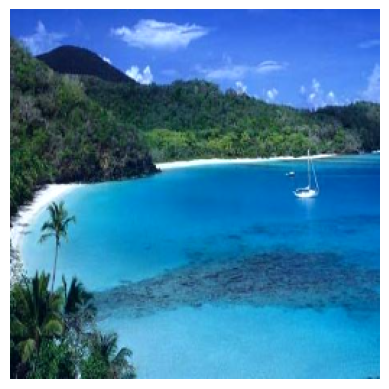

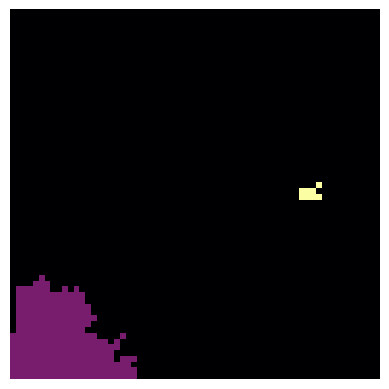

In [5]:
idx = 2453
plt.imshow(train_dataset[idx][0].permute(1, 2, 0) / 4 + 0.5) # just for visualization
plt.axis('off')
plt.show()
plt.imshow(train_dataset[idx][1], vmin=0, vmax=3, cmap='inferno')
plt.axis('off')
plt.show()

## Modules
For this section, you will have to implement the base functionalities and modules for the SegFormer. As illustrated in the **Figure 2** and **Section 3** in the paper, we divide SegFormer into encoder-decoder sections. The encoder mainly consists of multiple layers of MixTransformerEncoderLayer, which then consists of OverlapPatchMergiing + (EfficientSelfAttention + MixFFN). While patch merging is relatively intuitive, you have to implement EfficientSelfAttention following **Equation 1** in the paper, and MixFFN as illustrated in **Equation 3**. On the other hand, the decoder section also consists of multiple decoder blocks, ending with a MLP. Refer to **Equation 4** for this part.

In [6]:
# Combine adjacent patches to reduce feature map size, followed by LayerNorm
# Hint, patch merging can be accomplished with a single Conv2D module
class OverlapPatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size, stride, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=patch_size, stride=stride, padding=padding)
        self.norm = nn.LayerNorm(out_channels)

    def forward(self, patches):
        """Merge patches to reduce dimensions of input.

        :param patches: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        x = self.conv(patches)

        return x

In [30]:
# Perform attention with a reduced set of keys
# Hint, use a Linear layer followed by a LayerNorm before passing into MultiheadAttention
# equation 2 in paper

class EfficientSelfAttention(nn.Module):
    def __init__(self, channels, reduction_ratio, num_heads):
        super().__init__()
        assert channels % num_heads == 0, f"channels {channels} should be divided by num_heads {num_heads}."

        # self.Eff_SelfAtten = nn.Sequential(
        #     nn.Linear(channels, channels // reduction_ratio),
        #     nn.LayerNorm(channels // reduction_ratio),
        #     nn.MultiheadAttention(channels // reduction_ratio, num_heads),
        # )
        
        self.reduction_ratio = reduction_ratio
        self.num_heads = num_heads
        self.scale = None or ((channels // num_heads) ** (-0.5))
        self.q = nn.Linear(channels, channels, bias=True)
        self.kv = nn.Linear(channels, channels*2, bias=True)
        self.layer = nn.Linear(channels, channels)
        self.norm1 = nn.LayerNorm(channels)
        self.norm2 = nn.LayerNorm(channels)

        if reduction_ratio>1:
            self.conv = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=reduction_ratio, stride=reduction_ratio)
            self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        """ Perform self attention with reduced sequence length

        :param x: tensor of shape (B, N, C) where
            B is the batch size,
            N is the number of queries (equal to H * W)
            C is the number of channels
        :return: tensor of shape (B, N, C)
        """
        x_in = x
        B,N,C = x.shape
        H = W = torch.sqrt(torch.tensor(N)).int()

        # print(f"(EfficientSelfAttention) | before | self.q(x)| {x.shape}")
        q = (self.q(x).reshape(B,N,self.num_heads,C//self.num_heads).permute(0,2,1,3)).squeeze(1) 
        # print(f"(EfficientSelfAttention) | after | self.q(x)| {q.shape}")

        if self.reduction_ratio>1: 
            x_bar = x.permute(0,2,1).reshape(B,C,H,W)
            # print(f"(EfficientSelfAttention) | before | self.conv(x_bar)| {x_bar.shape}")
            x_bar = self.conv(x_bar).reshape(B,C,-1).permute(0,2,1)
            # print(f"(EfficientSelfAttention) | after | self.conv(x_bar)| {x_bar.shape}")
            x_bar = self.norm(x_bar)

            # print(f"(EfficientSelfAttention) | before | self.kv(x_bar)| {x_bar.shape}")
            kv = self.kv(x_bar)
            # print(f"(EfficientSelfAttention) | after | self.kv(x_bar)| {kv.shape}")
            kv = kv.reshape(B,-1,2,self.num_heads,C//self.num_heads).permute(2,0,3,1,4)
            # print(f"(EfficientSelfAttention) | after | reshape & permute | {kv.shape}")
        else:
            # print(f"(EfficientSelfAttention) | else | before | self.kv(x)| {x.shape}")
            kv = self.kv(x)
            # print(f"(EfficientSelfAttention) | else | after | self.kv(x)| {kv.shape}")
            kv = kv.reshape(B,-1,2,self.num_heads,C//self.num_heads).permute(2,0,3,1,4)
            # print(f"(EfficientSelfAttention) | else | after | reshape & permute | {kv.shape}")
        
        # print(f"(EfficientSelfAttention) | before | k&v | {kv[0].shape}, {kv[1].shape}")
        k, v = kv[0].squeeze(1), kv[1].squeeze(1)
        # print(f"(EfficientSelfAttention) | after | k&v | {k.shape}, {v.shape}")
        atten = ((q@k.transpose(-2,-1)) * self.scale).softmax(dim=-1)
        
        x = (atten@v).transpose(1,2).reshape(B,N,C)
        x = self.layer(x)
        # x = self.norm(x)

        B_new,N_new,C_new = x.shape

        assert B==B_new , f"batch {B} does not match after operation"
        assert C==C_new , f"# Class {C} does not match after operation"
        assert N==N_new , f"N {N} does not match after operation"

        # return x 
        return x + x_in  #Doubt here

In [8]:
# A feedforward network that mixes spatial information
# Should implement the following structure (inverse bottleneck):
#     mlp (channels -> expanded_channels)
#     depth-wise convolution (3 x 3)
#     activation function (gelu)
#     mlp (expanded_channels -> channels)
class MixFFN(nn.Module):
    def __init__(self, channels, expansion_factor):
        super().__init__()
        
        expanded_channels = channels * expansion_factor

        self.mlp1 = nn.Linear(channels, expanded_channels)
        self.dw_conv = nn.Sequential(
            nn.Conv2d(expanded_channels, expanded_channels, kernel_size=3, stride=1, padding=1, groups=expanded_channels),
            nn.GELU()
        )
        self.mlp2 = nn.Linear(expanded_channels, channels)

        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        """ Perform self attention with reduced sequence length

        :param x: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        # x_in = x

        # print(f"(MixFFN) | before | mlp1 | {x.shape}")
        x = self.mlp1(x)
        # print(f"(MixFFN) | after | mlp1 | {x.shape}")
        # print(f"(MixFFN) | before | dw_conv | {x.shape}")
        B,N,C = x.shape
        H = W = torch.sqrt(torch.tensor(N)).int()
        # print(f"(MixFFN) 1| before | dw_conv | {x.shape}")
        x = x.transpose(1,2).view(B,C,H,W)
        # print(f"(MixFFN) 2| before | dw_conv | {x.shape}")
        # x = x.flatten(2).transpose(1,2)
        # print(f"(MixFFN) 3| before | dw_conv | {x.shape}")
        x = self.dw_conv(x).flatten(2).transpose(1,2)
        # print(f"(MixFFN) | after | dw_conv | {x.shape}")

        # print(f"(MixFFN) | before | mlp2 | {x.shape}")
        x = self.mlp2(x)
        # print(f"(MixFFN) | after | mlp2 | {x.shape}")

        return x
        # return x + x_in

In [28]:
# Combine patch merging with n_layers of [attention followed by ffn]
class MixTransformerEncoderLayer(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size, stride, padding,
                 n_layers, reduction_ratio, num_heads, expansion_factor):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.reduction_ratio = reduction_ratio
        self.num_heads = num_heads
        self.expansion_factor = expansion_factor

        self.patch_embedding = nn.Conv2d(in_channels, out_channels, kernel_size=patch_size, stride=stride, padding=padding)
        self.n_layers = n_layers
        self.attention = EfficientSelfAttention(out_channels, reduction_ratio, num_heads)
        self.ffn = MixFFN(out_channels, expansion_factor)
        self.norm = nn.LayerNorm(out_channels)
        self.patch_merging = OverlapPatchMerging(in_channels, out_channels, patch_size, stride, padding)

    def forward(self, x):
        """ Run one block of the mix vision transformer

        :param x: tensor with shape (B, C, H, W) where
            B is the Batch size
            C is the number of Channels
            H and W are the Height and Width
        :return: tensor with shape (B, C, H, W)
        """
        # print()
        # print()
        # print(f"Starting MixTransformerEncoderLayer Block")
        # print(f"in_channels: {self.in_channels}, out_channels: {self.out_channels}, reduction_ratio: {self.reduction_ratio}, num_heads: {self.num_heads}, expansion_factor: {self.expansion_factor}")
        # x_in = x
        B, C, H, W = x.shape

        # print(f"(MixTransformerEncoderLayer) | before | self.patch_embedding(x)| {x.shape}")
        x = self.patch_merging(x)
        # print(f"(MixTransformerEncoderLayer) | after | self.patch_embedding(x)| {x.shape}")

        for _ in range(self.n_layers):
            # print(f"Layer No.: {_+1}/{self.n_layers}")

            x = x.flatten(2).transpose(1,2)
            # x = self.norm(x)

            # print(f"(MixTransformerEncoderLayer) | before | self.attention(x)| {x.shape}")
            x = self.attention(x)
            # print(f"(MixTransformerEncoderLayer) | after | self.attention(x)| {x.shape}")

            # B,N,C = x.shape
            # H = W = torch.sqrt(torch.tensor(N)).int()
            # x = x.reshape(B,H,W,C).permute(0,3,1,2)

            # print(f"(MixTransformerEncoderLayer) | before | self.ffn(x)| {x.shape}")
            x = x + self.ffn(x)
            x = self.norm(x)
            # print(f"(MixTransformerEncoderLayer) | after | self.ffn(x)| {x.shape}")
            
        # print(f"(MixTransformerEncoderLayer) | before | self.patch_merging(x)| {x.shape}")
        # x = self.patch_merging(x)
        # print(f"(MixTransformerEncoderLayer) | after | self.patch_merging(x)| {x.shape}")

        return x

In [22]:
class MLPDecoder(nn.Module):
    def __init__(self, in_channels, embed_channels, out_dims, num_classes):
        """Initialize MLP Decoder.
        :param in_channels: list of int, number of input channels for each layeer
        :param embed_channels: int, common embedding channels
        :param out_dims: tuple, dimensions of common feature map
        """
        super().__init__()
        c1_in, c2_in, c3_in, c4_in = in_channels

        self.linear_c1 = nn.Linear(c1_in, embed_channels)
        self.linear_c2 = nn.Linear(c2_in, embed_channels)
        self.linear_c3 = nn.Linear(c3_in, embed_channels)
        self.linear_c4 = nn.Linear(c4_in, embed_channels)

        self.fuse = ConvModule(in_channels=embed_channels*4, out_channels=embed_channels,
            kernel_size=1, norm_cfg=dict(type='BN', requires_grad=True))
        self.batch_norm = nn.BatchNorm2d(embed_channels)
        self.relu = nn.ReLU(inplace=True)
        self.final_linear = nn.Sequential(nn.Dropout(0.2),
            nn.Conv2d(embed_channels, num_classes, kernel_size=1))

    def forward(self, x):
        """ Take feature map to common shape
        :param x: list of tensors with shape (B, Ci, Hi, Wi)
            B is the Batch size
            Ci is the number of input Channels
            Hi and Wi are the input Height and Width
        :return: tensor with shape (B, C, H, W)
            B is the Batch size
            C is the number of output Channels
            H and W are the input Height and Width
        """
        x1, x2, x3, x4 = x
        B, _, _, _ = x1.shape

        c1_new = self.linear_c1(x1.flatten(2).transpose(1, 2))
        c1_new = c1_new.permute(0, 2, 1).reshape(B, -1, x1.shape[2], x1.shape[3])

        c2_new = self.linear_c2(x2.flatten(2).transpose(1, 2))
        c2_new = c2_new.permute(0, 2, 1).reshape(B, -1, x2.shape[2], x2.shape[3])
        c2_new = F.interpolate(c2_new, size=x1.size()[2:], mode='bilinear', align_corners=False)

        c3_new = self.linear_c3(x3.flatten(2).transpose(1, 2))
        c3_new = c3_new.permute(0, 2, 1).reshape(B, -1, x3.shape[2], x3.shape[3])
        c3_new = F.interpolate(c3_new, size=x1.size()[2:], mode='bilinear', align_corners=False)

        c4_new = self.linear_c4(x4.flatten(2).transpose(1, 2))
        c4_new = c4_new.permute(0, 2, 1).reshape(B, -1, x4.shape[2], x4.shape[3])
        c4_new = F.interpolate(c4_new, size=x1.size()[2:], mode='bilinear', align_corners=False)

        # print(f"(Decoder) c1_new: {c1_new.shape}, c2_new: {c2_new.shape}, c3_new: {c3_new.shape}, c4_new: {c4_new.shape}")

        x = torch.cat([c1_new, c2_new, c3_new, c4_new], dim=1)

        # print(f"(Decoder) | before | self.fuse(x)| {x.shape}")
        x = self.fuse(x)
        # print(f"(Decoder) | after | self.fuse(x)| {x.shape}")

        x = self.relu(self.batch_norm(x))

        # print(f"(Decoder) | before | self.final_linear(x)| {x.shape}")
        x = self.final_linear(x)
        # print(f"(Decoder) | after | self.final_linear(x)| {x.shape}")

        return x

## Model and Training
We have provided you with a near-complete network template which you can indicate how a complete SegFormer is structured and how it calls the modules we have built. For validation step, you need to implement mean IoU as paper suggests.

In [16]:
class SegFormer_B0(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder_blocks = nn.ModuleList([
            MixTransformerEncoderLayer(3, 32, patch_size=7, stride=4, padding=3, n_layers=2, reduction_ratio=8, num_heads=1, expansion_factor=8),
            MixTransformerEncoderLayer(32, 64, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=4, num_heads=2, expansion_factor=8),
            MixTransformerEncoderLayer(64, 160, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=2, num_heads=5, expansion_factor=4),
            MixTransformerEncoderLayer(160, 256, patch_size=3, stride=2, padding=1, n_layers=2, reduction_ratio=1, num_heads=8, expansion_factor=4)
        ])
        self.decoder = MLPDecoder([32, 64, 160, 256], 256, (64, 64), 4)
        self.loss = nn.CrossEntropyLoss()
        self.train_losses = []  # To store training losses over epochs
        self.val_mious = []

    def forward(self, images):
        embeds = [images]
        for block in self.encoder_blocks:
            embeds.append(block(embeds[-1]))
        return self.decoder(embeds[1:])

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-5)
        return optimizer

    def miou(self, prediction, targets):
        threshold = 1e-6
        iou = 0
        # Before calculating IoU
        C = prediction.size()[1]
        og_c = C
        pred = prediction.argmax(dim=1) 
        for i in range(C):
            mask_target = targets == i
            mask_pred = pred == i
            if mask_target.sum() == 0 and mask_pred.sum() == 0:
                og_c -= 1
                continue
            if mask_target.size() != mask_pred.size():
                print(f"Dimension mismatch: mask_target={mask_target.size()}, maskPred={mask_pred.size()}")
            union = torch.logical_or(mask_pred, mask_target).sum().item()
            intersection = torch.logical_and(mask_pred, mask_target).sum().item()
            iou = iou + intersection / (union + threshold)  
        miou = iou / og_c
        return miou

    def training_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self.forward(images)
        # predictions = F.interpolate(predictions, size=targets.size()[1:], mode='bilinear', align_corners=False)
        loss = self.loss(predictions, targets)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self.forward(images)
        miou = self.miou(predictions, targets)
        self.log('miou', miou, prog_bar=True)

    def on_train_epoch_end(self):
        # Store training loss at the end of each epoch
        train_loss = self.trainer.callback_metrics['train_loss'].item()
        self.train_losses.append(train_loss)

    def on_validation_epoch_end(self):
        # Store validation mean IoU at the end of each epoch
        val_miou = self.trainer.callback_metrics['miou'].item()
        self.val_mious.append(val_miou)

        # Optionally, plot Mean IoU against epochs after the last validation epoch
        if self.current_epoch == self.trainer.max_epochs - 1:
            # self.plot_miou_vs_epochs()
            pass

    # def plot_miou_vs_epochs(self):
    #     plt.figure(figsize=(10, 5))
    #     plt.plot(range(len(self.val_mious)), self.val_mious, label='Mean IoU')
    #     plt.xlabel('Epoch')
    #     plt.ylabel('Mean IoU')
    #     plt.title('Mean IoU Over Epochs')
    #     plt.legend()
    #     plt.show()

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
model = SegFormer_B0()
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=30)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type             | Params
----------------------------------------------------
0 | encoder_blocks | ModuleList       | 3.7 M 
1 | decoder        | MLPDecoder       | 395 K 
2 | loss           | CrossEntropyLoss | 0     
----------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.487    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


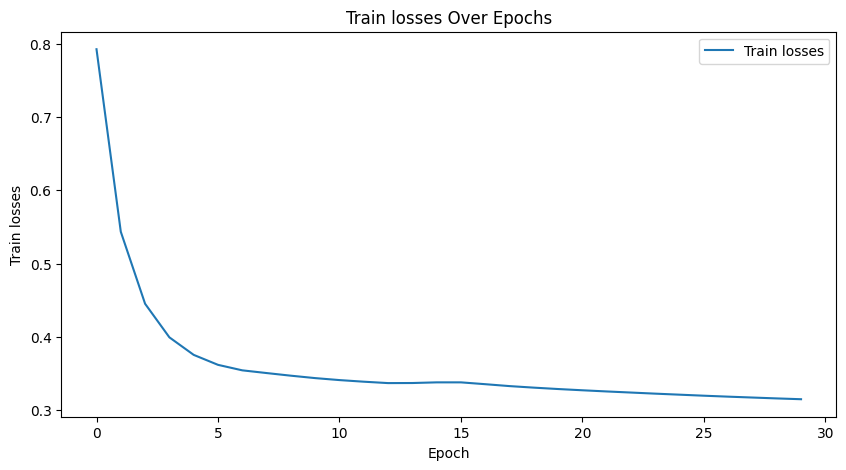

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(model.train_losses)), model.train_losses, label='Train losses')
plt.xlabel('Epoch')
plt.ylabel('Train losses')
plt.title('Train losses Over Epochs')
plt.legend()
plt.show()

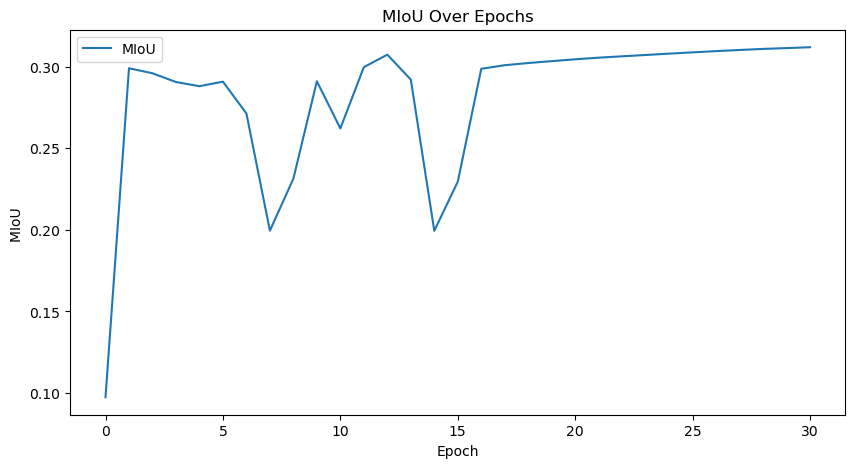

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(model.val_mious)), model.val_mious, label='MIoU')
plt.xlabel('Epoch')
plt.ylabel('MIoU ')
plt.title('MIoU Over Epochs')
plt.legend()
plt.show()

In [ ]:
checkpoint_path = 'new_checkpoint.ckpt'
torch.save(model.state_dict(), checkpoint_path)

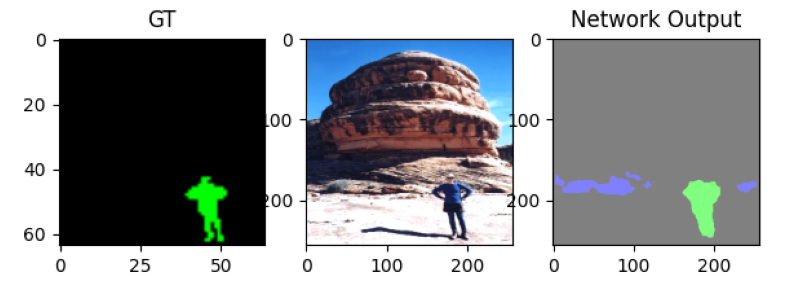

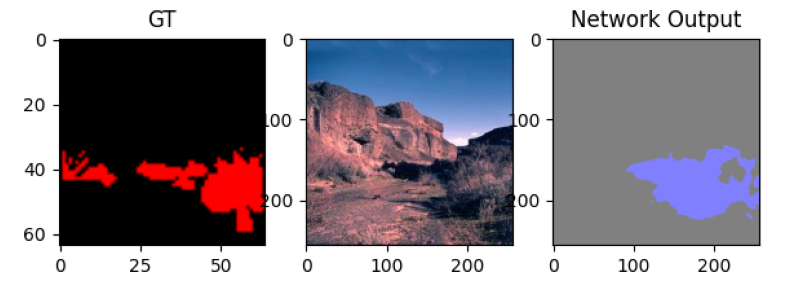

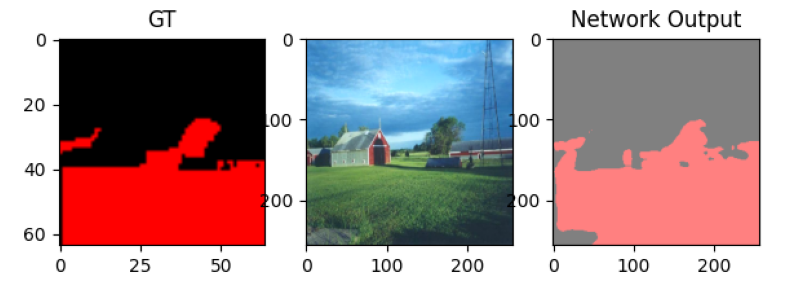

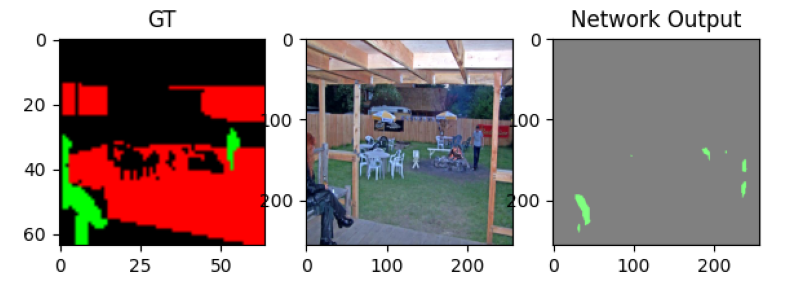

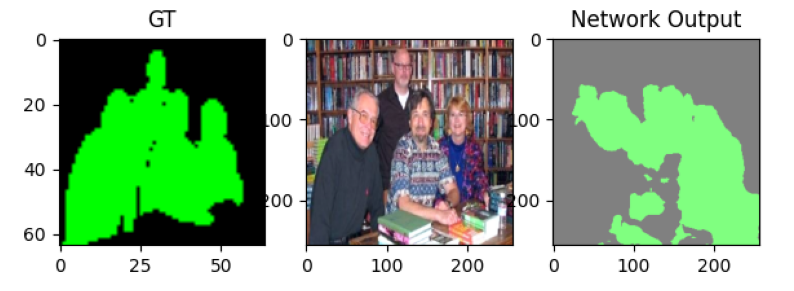

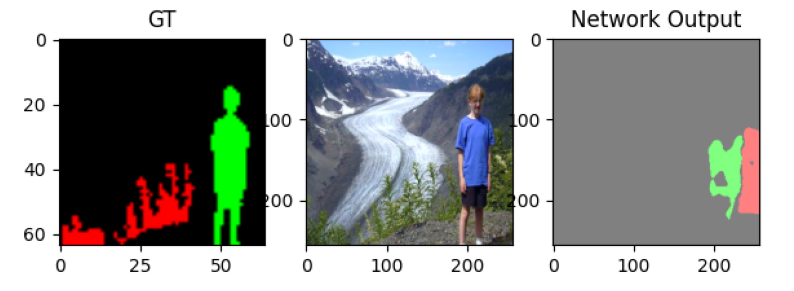

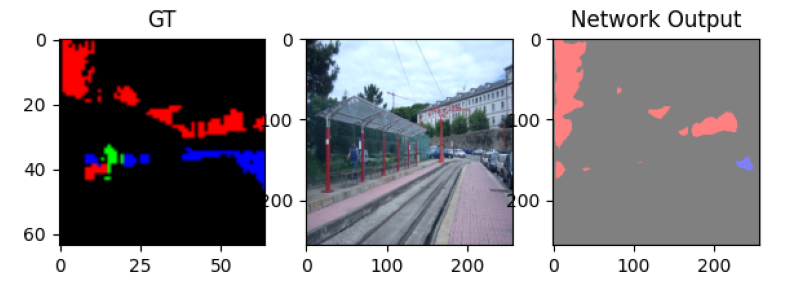

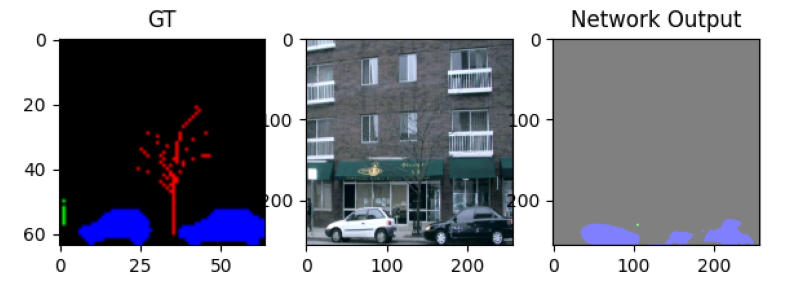

In [ ]:
import random
model = SegFormer_B0.load_from_checkpoint('/Users/renu/Desktop/Upenn/Sem_3/CIS_6800/Assignments/Segformer/lightning_logs/version_4/checkpoints/epoch=29-step=10380.ckpt')
dataset = val_dataset

model.eval()
for i in range(8):
    with torch.no_grad():
        idx = random.randint(0, 1000)
        pred = model(dataset[idx][0].unsqueeze(0).to("mps"))
        pred = torch.argmax((F.interpolate(pred, size=(256,256), mode='bilinear', align_corners=True)), dim=1).squeeze(0).detach().cpu().numpy()
    img = (dataset[idx][0].permute(1, 2, 0) / 4 + 0.5).numpy()
    label = (dataset[idx][1]).numpy()
    colors = np.array([[0, 0, 0],
                       [255, 0, 0],
                       [0, 255, 0],
                       [0, 0, 255],
                       [255, 255, 0]])
    #Plotting
    fig , axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(colors[label], cmap='jet', interpolation='bilinear')
    axes[0].set_title('GT')
    axes[1].imshow(img)
    # axs[1].set_title('Raw Image')
    axes[2].imshow(colors[pred], alpha=0.5) 
    axes[2].set_title('Network Output')
    plt.show()

## Results
Show your training curves and results on several images from the validation set. Provide a qualitative description of the performance of your model. Don't forget to upsample your predicted segmentation mask to the same resolution as the image! Segformer indeed has achieved great performance, there is a short demo on Cityspaces-C corrupted dataset on [YouTube](https://www.youtube.com/watch?v=J0MoRQzZe8U').

## Discussion Question
1. Why do we overlap and merge patches when reducing dimensions instead of e.g. max pool?
2. How does efficient self-attention affect the performance of the model?
3. Why do we only have one activation function in MixFFN?
4. If we removed padding='same' in MixFFN, would the performance of our model be affected? Why or why not? Suppose that there are no dimensional issues caused by this.
5. What is the difference between cross-entropy loss and miou? Why do we not use the miou to train?
6. Why are transformers especially suitable for this architecture? Namely, passing through different feature map stages and using a very small decoder. What problems might arise if we used convolutions instead?
7. Do you think that adding an FPN makes sense for this architecture? Justify your answer.
8. Your achieved performance is likely not very high, considering the simplicity of the data set. This assignment makes several simplications to the training process that contribute to this. Choose two such simplifications and explain why they degrade the achieved performance.

# Answers:

1. We overlap and merge patches when reducing dimensions instead of max pool because max pooling returns the maximum value within the pooling window which leads loss of detailed spatial information, where as overlapping and merging patches helps preserve spatial information better. Also overlapping and merging patches leads to preserving both low level and high level semantic information obtaining hierarchical feature maps, capturing more local context and spatial information. This further leads to positional in-variance. Not incorporating overlapping patches could result in a loss of information at the boundaries between patches. Overlapping patches aids in the sharing and propagation of information among adjacent patches.

2. Self-attention layer is the main computation bottleneck of the encoders. In the original multi-head self-attention process, each head's dimensions (Q, K, V) are N × C, where N represents the length of the sequence (N = H × W for image data). The computational complexity of this process is O(N^2), which becomes problematic for large image resolutions. In this approach, sequence reduction process (R= reduction ratio) is used  reducing the complexity of the self-attention mechanism from O(N^2) to O((N^2)/R). Self-attention layer in turn reduces computational complexity and training speed.  Self-attention mechanisms hence lead to better generalisation performance.

3. We only have one activation function in MixFFN because it helps keep the model simple while having reasonable computational efficiency.Here we used depth-wise convolutions for reducing the number of parameters and improving efficiency. Although it seems that multiple activation functions can increase the model's performance, it may be lead to complicated training. Use of single GELU activation function in Mix-FFN seems like an effective way of introducing an ample degree of non-linearity to comprehend complex patterns in the data, all the while ensuring computational efficiency.

4. Removing the padding='same' parameter in MixFFN might impact the model's performance.:  padding='same' ensures that the output size is the same as input size. If we don't use padding, important details at the edges of the feature maps could be lost. This could make it harder for the model to understand and recognise spatial patterns effectively. Mix-FFN takes into account the impact of zero padding to allow location information to leak. This is achieved by directly employing a 3 × 3 convolution in the feed-forward network (FFN).

5. MIoU measures the overlap between the predicted segmentation masks and the ground truth masks for each class. It computes the Intersection over Union (IoU) for each class and then calculates the average over all classes. Cross-entropy loss is also called log loss/log-likelihood loss. Cross entropy loss represents the difference between the predicted probability with the true distribution of the target classes. Cross-entropy loss increases as the predicted probability diverges from the actual label. Generally we use cross entropy for training and MIoU for evaluation, this is because during training,  we need the loss to be differentiable in order to optimize the model parameters through back-propagation. MIoU is useful for evaluating the performance of the segmentation model, but since it is non-differentiable it isn’t optimal for training.

6. Transformers especially suitable for this architecture because different stages of feature maps are processed separately and then combined. The self-attention mechanism in transformers captures both low level and high level features, i.e., it captures hierarchical features. When it comes to passing through different feature map stages and using a very small decoder, transformers tend to be more efficient and adaptable. Some of the problems that might arise if we used convolutions instead is that it may not adapt to varying spatial relationships in different feature map stages because the have fixed receptive field, constained by the kernel size leading to limited global context. Also convolutions need too many parameters which make it computationally expensive.

7. Adding an FPN would not make much sense for this architecture since SegFormer already employs a transformer-based architecture, which captures information from different spatial scales. Therefore, adding an FPN would have little to no affect. Adding an FPN may lead increase in the computational load providing maybe very little improvement.

8. Yes our achieved performance is likely not very high, considering the simplicity of the data set. This assignment makes several simplifications to the training process that contributes to this. In the configure_optimizers method, we used a fixed learning rate of 1e-5 for the AdamW optimizer. While this learning rate might be suitable for some tasks, it's generally a good practice to experiment with different learning rates during training. Using learning rate schedules or techniques like learning rate finders to explore an appropriate learning rate dynamically might aid in better performance. The code does not include any dropout layers or other regularization techniques. Dropout is a common regularization technique that randomly sets a fraction of input units to zero during training, which helps prevent overfitting. Regularization techniques are essential to improve the generalization of a model and its performance on unseen data. Without dropout or similar regularization mechanisms, the model might be prone to overfitting, especially when dealing with a relatively simple dataset. Some other simplifications are: we used a simplified subset of ADE20K with only four classes: "plant", "person/animal", "vehicle", and "background”; and we have trained it only for some epochs given the restriction of computational resources. They degrade the achieved performance because we have trained only on a subset of data, leading to lower efficiency.